In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt

import lumicks.pylake as lk

# %matplotlib inline

In [2]:
# filenames = lk.download_from_doi("10.5281/zenodo.7729929", "test_data")

<div class="alert alert-block alert-danger"><b>Warning: </b>This is beta functionality. While usable, this has not yet been tested in a large number of different scenarios. The API may also still be subject to change.</div>

# Twistable Worm-Like-Chain Fitting

[Download this page as a Jupyter notebook](https://lumicks-pylake.readthedocs.io/en/stable/_downloads/501ebc5dc19f5f65b7b0dd0a3c1ff768/twlc_fitting.ipynb)

In this notebook, we analyze force extension data of DNA over its full range of structural transitions under mechanical stress (0 - 60 pN). The twistable worm-like chain model (tWLC) takes twisting deformations on the DNA double helix into account. Here we will use this model to describe the mechanical response of DNA at such high forces.

Let’s load and plot the data first:

In [3]:
file = lk.File("sam_data/20240123-135716 FD Curve DNA_1_2um_sec 2.h5")
list(file.fdcurves)

['DNA_1_2um_sec']

In [4]:
fd_curves ={}
key, curve = file.fdcurves.popitem()
fd_curves[key]  = curve


interactive(children=(Dropdown(description='curve', options=('DNA_1_2um_sec',), value='DNA_1_2um_sec'), Output…

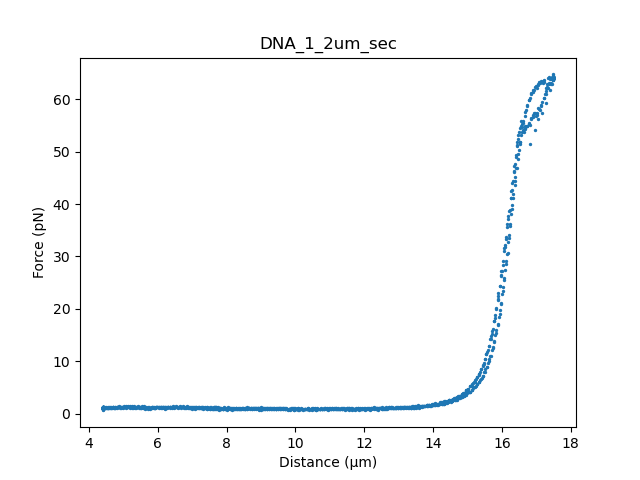

In [5]:
selector = lk.FdDistanceRangeSelector(fd_curves)
plt.show() 

In [6]:
# file = lk.File("twlc_data//20200430-163932 FD Curve FD_1_control_forw.h5")  
# file = lk.File("test_data/fdcurve.h5")
# fd_curve = file.fdcurves["FD_1_control_forw"]
# fd_curve = file.fdcurves["FD_5_control_forw"]
fd_curve = file.fdcurves["DNA_1_2um_sec"]
fd_curve.plot_scatter()

## Set up a basic model first

We clearly see that the force starts levelling out at high forces in the data. We’ll need something rather complex in order to capture this behavior. The twistable worm-like chain (tWLC) model can describe the untwisting behavior of DNA that becomes apparent in the 30-60 pN force range. However, the model’s complexity also incurs some challenges.

Parameter estimation typically begins from an initial guess, and if this initial guess is bad, it can get stuck at an estimated set of parameters that are suboptimal, a so-called local optimum. One way to mitigate this, is to start with better initial values.

In this notebook, we fit the region before the force begins levelling out (i.e. 30 pN) first with a regular worm-like chain model and then use those estimates as initial guesses to fit the tWLC model.

Depending on your experiments, small offsets can be present in the data. For instance, the bead diameter may vary slightly from experiment to experiment, or the force may have experienced some drift. We incorporate an offset in both distance and force to compensate for small offsets that may exist in the data. Let’s set up the Odijk worm-like chain model and create the fit:

In [7]:
# m_odijk = lk.ewlc_odijk_force("DNA").subtract_independent_offset() + lk.force_offset("DNA")
m_odijk = lk.ewlc_odijk_force("DNA") + lk.force_offset("DNA")

fit_odijk = lk.FdFit(m_odijk)

In [8]:
for i , curve in enumerate(selector.fdcurves.values()):
    force_data = curve[0].f.data
    distance_data = curve[0].d.data
    fit_odijk[m_odijk].add_data(f"Selected data",
                        force_data[distance_data > 0.5e-6],
                        distance_data[distance_data > 0.5e-6])

In [9]:
fit_odijk["DNA/Lc"].value = 16
fit_odijk["DNA/Lp"].value = 50
fit_odijk["DNA/St"].value = 1500
fit_odijk["DNA/St"].lower_bound = 250
fit_odijk["DNA/f_offset"].upper_bound = 2
fit_odijk["DNA/f_offset"].lower_bound = -2

fit_odijk.fit()
fit_odijk

Name,Value,Unit,Fitted,Lower bound,Upper bound
DNA/Lp,57.6529,[nm],True,0.001,100
DNA/Lc,16.2392,[micron],True,0.00034,inf
DNA/St,1525.42,[pN],True,250,inf
kT,4.11,[pN*nm],False,3.77,8
DNA/f_offset,0.836353,[pN],True,-2,2


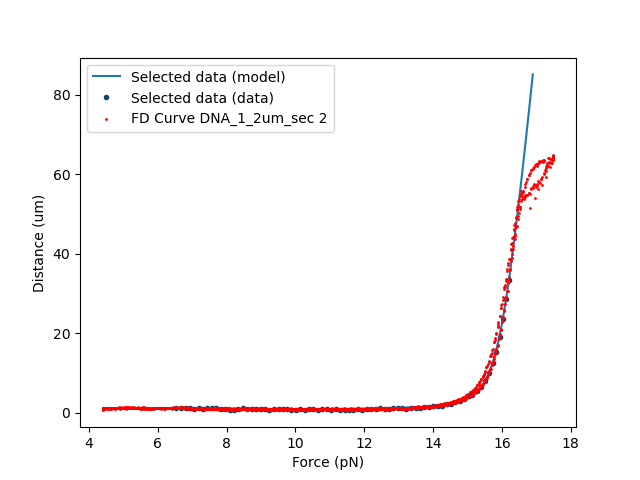

In [10]:
plt.figure()
fit_odijk[m_odijk].plot(independent=np.arange(10, 17, 0.1))
for name,fd in file.fdcurves.items():
    plt.scatter(fd.d.data, fd.f.data,s=1,c='r', label="FD Curve DNA_1_2um_sec 2")
plt.xlabel("Force (pN)")
plt.ylabel("Distance (um)")
plt.legend()
plt.show()

In [ ]:
profile = fit_odijk.profile_likelihood('DNA/Lc', num_steps=1000, min_step=0.00001,confidence_level=0.95)
[profile.lower_bound, profile.upper_bound]

Considering that this model only describes the force-extension behaviour at low forces (0.1 - 30 pN), we have to extract the data that is relevant to us. We can obtain this data from the force-distance curve as follows:

In [ ]:
force = fd_curve.f.data
distance = fd_curve.d.data

We only wish to use the forces below 30, so we filter the data according to this requirement:

In [ ]:
mask = force < 30
distance = distance[mask]
force = force[mask]

Now we are ready to add this data to the fit, but first, we must constrain the distance offset to help the fitting, as this provides a lot of additional freedom in the model:

In [ ]:
fit_odijk.add_data("Inverted Odijk", force, distance)
fit_odijk["DNA/d_offset"].upper_bound = 0.01
fit_odijk["DNA/d_offset"].lower_bound = -0.01

And fit the model:

In [ ]:
fit_odijk.fit()

## Set up the twistable worm like chain model

By default, the [`twlc_distance()`](https://lumicks-pylake.readthedocs.io/en/stable/examples/twlc_fitting/../../_api/lumicks.pylake.twlc_distance.html#lumicks.pylake.twlc_distance) model provided with pylake outputs the distance as a function of force. However, we typically want to fit force as a function of distance. To achieve this, we can invert the model using its `invert` function at the cost of slowing down the fit. Alternatively, we have a faster way of achieving this in pylake, by using the dedicated [`twlc_force()`](https://lumicks-pylake.readthedocs.io/en/stable/examples/twlc_fitting/../../_api/lumicks.pylake.twlc_force.html#lumicks.pylake.twlc_force) model:

In [ ]:
m_DNA = lk.twlc_force("DNA").subtract_independent_offset() + lk.force_offset("DNA")
fit_twlc = lk.FdFit(m_DNA)

## Load the full data into the model

In the plot showing the data, we could see that there is a small transition event at the end of the Fd curve. The model will not be able to capture this behaviour and therefore it is best to remove this section prior to fitting:

In [ ]:
force = fd_curve.f.data
distance = fd_curve.d.data
mask = distance < 2.88
distance = distance[mask]
force = force[mask]

Now we can load the data into the model:

In [ ]:
fit_twlc.add_data("Twistable WLC", force, distance)

We could add more datasets in a similar manner, but in this example, we only fit a single model. Let’s load the parameters from our previous fit to use them as initial guesses for this one. We also fix the twist rigidity and critical force to values from literature (analogous to Broekmans et al. “DNA twist stability changes with magnesium (2+) concentration.” Physical Review Letters 116, 258102 (2016)):

In [ ]:
fit_twlc.update_params(fit_odijk)

# Fix twist rigidity and critical force to literature values.
fit_twlc["DNA/C"].value = 440
fit_twlc["DNA/C"].fixed = True
fit_twlc["DNA/Fc"].value = 30.6
fit_twlc["DNA/Fc"].fixed = True

## Fit the model

Considering that the tWLC model is more difficult to evaluate, this may take a while. This is also why we choose to enable verbose output:

In [ ]:
fit_twlc.fit(verbose=2)
plt.show()

## Plotting the results

After fitting we can plot our results and print our parameters by invoking `fit.plot()` and `fit.params` respectively:

In [ ]:
fit_twlc.plot()
plt.xlabel("Distance [$\\mu$m]")
plt.ylabel("Force [pN]");

We can also show the parameters:

In [ ]:
fit_twlc.params

These seem to agree well with what’s typically found for dsDNA.